# Security Log Analysis System Demo

This notebook demonstrates a sophisticated multi-agent system for analyzing security logs, with a focus on detecting security anomalies using a parallel execution model with voting-based consensus.

## System Architecture

The system employs the following components:
1. **Planner Agent** - Creates the analysis plan and selects specialist agents
2. **Worker Specialists** - Five parallel agents with expertise in different MITRE ATT&CK tactics
3. **Critique Agent** - Implements voting-based consensus to prioritize findings
4. **Judge Agent** - Provides final verdict and remediation steps
5. **Visualization Module** - Creates visual representations of findings

Let's start by setting up the necessary imports and dependencies.

In [18]:
import os
import json
import gzip
import time
import random
import matplotlib.pyplot as plt
import networkx as nx

from typing import List, Dict, Any, TypedDict
from datetime import datetime
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langsmith import traceable
from collections import deque
from IPython.display import display, HTML, Image


# Import custom agents (assuming agents directory is accessible)
from agents.planner import Planner
from agents.worker_factory import WorkerFactory
from agents.critique import Critique
from agents.judge import Judge
from utils.visualization import visualize_results

# Load environment variables (for API keys)
load_dotenv()

True

## Setting Up Demo Log Data

Let's create sample log files for different attack scenarios. These samples represent common attack patterns that security analysts might encounter.

In [3]:
def create_demo_logs():
    """Create demo log files for different attack scenarios"""
    demo_dir = "demo_logs"
    if not os.path.exists(demo_dir):
        os.makedirs(demo_dir)

    # Define demo scenarios with sample log data
    scenarios = {
        "lateral_movement": {
            "query": "Can you identify any lateral movement or host discovery activities in the logs?",
            "logs": [
                {
                    "timestamp": "2024-03-15T10:34:56Z",
                    "event": {"type": "ProcessRollup2"},
                    "process": {
                        "name": "cmd.exe",
                        "command_line": "cmd.exe /c net use \\\\10.1.1.12\\admin$ /user:domain\\admin password123",
                        "pid": 1234
                    },
                    "user": {"username": "jsmith"}
                },
                {
                    "timestamp": "2024-03-15T10:35:10Z",
                    "event": {"type": "NetworkConnectionIP4"},
                    "process": {"name": "cmd.exe", "pid": 1234},
                    "network": {
                        "direction": "outbound",
                        "protocol": "tcp",
                        "local_ip": "10.1.1.5",
                        "local_port": 49321,
                        "remote_ip": "10.1.1.12",
                        "remote_port": 445
                    }
                }
            ]
        },
        "credential_theft": {
            "query": "Check if there are any credential theft attempts in the logs",
            "logs": [
                {
                    "timestamp": "2024-03-15T11:22:15Z",
                    "event": {"type": "ProcessRollup2"},
                    "process": {
                        "name": "rundll32.exe",
                        "command_line": "rundll32.exe C:\\Windows\\System32\\comsvcs.dll, MiniDump 624 C:\\temp\\lsass.dmp full",
                        "pid": 2345
                    },
                    "user": {"username": "jsmith"}
                },
                {
                    "timestamp": "2024-03-15T11:22:18Z",
                    "event": {"type": "FileWritten"},
                    "file": {
                        "path": "C:\\temp\\lsass.dmp",
                        "size": 45678912
                    },
                    "process": {"name": "rundll32.exe", "pid": 2345}
                }
            ]
        },
        "data_exfiltration": {
            "query": "Check if there's evidence of data exfiltration in these logs",
            "logs": [
                {
                    "timestamp": "2024-03-15T12:15:30Z",
                    "event": {"type": "NetworkConnectionIP4"},
                    "process": {"name": "powershell.exe", "pid": 3456},
                    "network": {
                        "direction": "outbound",
                        "protocol": "tcp",
                        "local_ip": "10.1.1.5",
                        "local_port": 54321,
                        "remote_ip": "45.67.89.123",
                        "remote_port": 443
                    }
                },
                {
                    "timestamp": "2024-03-15T12:15:35Z",
                    "event": {"type": "FileWritten"},
                    "file": {
                        "path": "C:\\temp\\data.zip",
                        "size": 1024000
                    },
                    "process": {"name": "powershell.exe", "pid": 3456}
                }
            ]
        }
    }

    # Write each scenario to a separate file
    for scenario, data in scenarios.items():
        file_path = os.path.join(demo_dir, f"{scenario}.json")
        with open(file_path, 'w') as f:
            for log in data["logs"]:
                f.write(f"{json.dumps(log)}\n")
                
    print(f"Created demo log files in '{demo_dir}' directory")
    print(f"Available scenarios: {', '.join(scenarios.keys())}")

    return scenarios

# Create the demo logs
scenarios = create_demo_logs()

Created demo log files in 'demo_logs' directory
Available scenarios: lateral_movement, credential_theft, data_exfiltration


## Core Log Analysis System Components

Let's implement the core components of the log analysis system. This includes the state type definition, log parsing, and the LangGraph workflow.

In [28]:
!pip install pygraphviz

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp312-cp312-linux_x86_64.whl size=174115 sha256=e90be600451847b3ff29659ee436e59334b6c0705b7e656cfe7f13cde8449aaa
  Stored in directory: /home/jayasimha/.cache/pip/wheels/e1/2f/c3/0f7719eda975973b474b79b98e1208e635565c1e4dac777ac8
Successfully built pygraphviz


In [26]:
from IPython.display import  Image, display


# Global counter for tracking iterations
ITERATION_COUNT = 0

def display_graph(graph):
    try:
        display(Image(graph.get_graph().draw_png()))
        # display(Image(graph.get_graph().print_ascii()))
    except Exception as e:
        print(f"Error displaying graph: {e}")
        pass 
    
class AgentState(TypedDict):
    human_input: str
    log_content: str
    plan: str
    worker_definitions: List[Dict[str, str]]
    worker1_output: Dict[str, Any]
    worker2_output: Dict[str, Any]
    worker3_output: Dict[str, Any]
    worker4_output: Dict[str, Any]
    worker5_output: Dict[str, Any]
    critique_output: Dict[str, Any]
    final_judgment: Dict[str, Any]
    max_iterations: int
    workers_to_revise: List[int]  # Track which workers need revision
    iteration_count: int  # Track iteration count in state

def read_log_data(file_path: str, max_events: int = 50) -> str:
    """Read and parse log data from a file, with random sampling"""
    events = deque(maxlen=max_events)
    total_events = 0

    # Check if file is gzipped
    is_gzipped = file_path.endswith('.gz')

    # Open appropriate file handler
    if is_gzipped:
        opener = gzip.open
        mode = 'rt'  # text mode for gzip
    else:
        opener = open
        mode = 'r'

    try:
        with opener(file_path, mode) as file:
            # First pass: count total events and collect random sample
            for line in file:
                if line.strip():  # Skip empty lines
                    try:
                        event = json.loads(line)
                        total_events += 1
                        
                        # Reservoir sampling algorithm
                        # For the first max_events, add them directly
                        if total_events <= max_events:
                            events.append(event)
                        else:
                            # For subsequent events, randomly replace existing events
                            # with probability max_events/total_events
                            if random.random() < max_events / total_events:
                                # Randomly select an event to replace
                                events[random.randrange(max_events)] = event
                    except json.JSONDecodeError:
                        print(f"Warning: Could not parse line as JSON: {line[:100]}...")
                        continue

        print(f"Total events in file: {total_events}")
        print(f"Randomly sampled {len(events)} events")

    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return f"Error reading log data: {e}"

    # Convert the events to a well-formatted JSON string
    return json.dumps(list(events), indent=2)

@traceable(name="create_log_analysis_graph")
def create_log_analysis_graph():
    # Initialize OpenAI LLM
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    # Initialize our agents
    planner = Planner(llm)
    worker_factory = WorkerFactory(llm)
    critique = Critique(llm)
    judge = Judge(llm)

    # Build the graph with typed state
    workflow = StateGraph(AgentState)

    # Debug wrapper for state tracking
    def debug_node(name, func):
        def wrapped(state):
            print(f"\n>>> {name} START")
            result = func(state)
            print(f"<<< {name} END")
            return result
        return wrapped

    # Add planner node with debug wrapper
    workflow.add_node("planner", debug_node("PLANNER", planner))
    
    # Define worker creation with debug wrappers
    def create_worker(num):
        def worker_func(state):
            worker_defs = state.get("worker_definitions", [])
            if len(worker_defs) >= num:
                worker_def = worker_defs[num - 1]
                return worker_factory.create_worker(num, worker_def["role"], worker_def["tasks"])(state)
            return {
                f"worker{num}_output": {"role": "Default", "analysis": "No specific role defined."}
            }
        return debug_node(f"WORKER-{num}", worker_func)

    # Add all 5 worker nodes for parallel execution
    for i in range(1, 6):
        workflow.add_node(f"worker{i}", create_worker(i))
    
    # Add critique and judge nodes
    workflow.add_node("critique", debug_node("CRITIQUE", critique))
    workflow.add_node("judge", debug_node("JUDGE", judge))

    # Define edges for parallel execution
    # Planner to all workers in parallel
    for i in range(1, 6):
        workflow.add_edge("planner", f"worker{i}")
    
    # All workers to critique in parallel
    for i in range(1, 6):
        workflow.add_edge(f"worker{i}", "critique")
    
    # Critique directly to judge (no revision loop)
    workflow.add_edge("critique", "judge")
    
    # Judge is the final node
    workflow.add_edge("judge", END)

    # Set the entry point
    workflow.set_entry_point("planner")


    return workflow.compile()

## Main Analysis Function

Now let's implement the main function to run the log analysis.

In [5]:
@traceable(name="log_analysis_multi_agent")
def run_log_analysis(human_input: str, log_file: str, max_events: int = 50, max_iterations: int = 3):
    """
    Run the log analysis multi-agent system on log data.

    Args:
        human_input: User query for analysis
        log_file: Path to the log data file
        max_events: Maximum number of events to include in the analysis
        max_iterations: Maximum number of planning iterations before forcing completion
    """
    global ITERATION_COUNT
    
    # Reset the global iteration counter for new runs
    ITERATION_COUNT = 0
    
    # Read and parse the log data
    log_content = read_log_data(log_file, max_events)

    # Create initial state with max_iterations
    initial_state = {
        "human_input": human_input,
        "log_content": log_content,
        "max_iterations": max_iterations,
        "workers_to_revise": [],  # Initialize empty list of workers to revise
        "iteration_count": 0      # Initialize iteration count in state
    }

    # Print initial state for debugging
    print(f"Initial state: global ITERATION_COUNT={ITERATION_COUNT}, max_iterations={max_iterations}")

    log_analysis_graph = create_log_analysis_graph()

    # Display the Graph
    display_graph(log_analysis_graph)

    # Get the final result
    result = log_analysis_graph.invoke(initial_state)

    # Print final state for debugging
    print(f"\n=== ANALYSIS COMPLETE ===")
    print(f"Final iteration count: {ITERATION_COUNT}")

    # Add the iteration count to the result
    result["iteration_count"] = ITERATION_COUNT
    
    return result

## Interactive Demo Function

Now let's create an interactive demo function that we can use in this notebook.

In [7]:
def run_demo(scenario=None):
    """Run interactive demonstration of the security log analysis system"""
    
    # Use specified scenario or display options
    if not scenario or scenario not in scenarios:
        print("\nAvailable demo scenarios:")
        for i, (key, value) in enumerate(scenarios.items(), 1):
            print(f"{i}. {key.replace('_', ' ').title()}: {value['query']}")
            
        try:
            choice = int(input("\nSelect a scenario number: "))
            if 1 <= choice <= len(scenarios):
                scenario = list(scenarios.keys())[choice - 1]
            else:
                print("Invalid choice. Using 'lateral_movement' scenario.")
                scenario = "lateral_movement"
        except (ValueError, IndexError):
            print("Invalid choice. Using 'lateral_movement' scenario.")
            scenario = "lateral_movement"

    # Get the selected scenario
    selected = {
        "query": scenarios[scenario]["query"],
        "log_file": f"demo_logs/{scenario}.json"
    }
    
    # Display header
    print("\n" + "="*80)
    print(f"DEMO: Security Log Analysis System")
    print("="*80)
    print(f"\nInvestigation Request: {selected['query']}")
    print(f"Analyzing log file: {selected['log_file']}")
    print("\nStarting multi-agent analysis...\n")

    # Run the analysis
    start_time = time.time()
    result = run_log_analysis(selected['query'], selected['log_file'])
    end_time = time.time()

    # Display results
    print("\n" + "="*80)
    print("RESULTS")
    print("="*80)

    print(f"\nAnalysis completed in {end_time - start_time:.2f} seconds\n")

    print(f"ANALYSIS PLAN:")
    print(f"{result['plan']}\n")

    print("SPECIALIST FINDINGS:")
    for i in range(1, 6):
        worker_key = f"worker{i}_output"
        if worker_key in result:
            role = result[worker_key]['role']
            print(f"\n{i}. {role} Analysis:")
            print("-" * (len(role) + 11))
            print(f"{result[worker_key]['analysis']}\n")

    print("\n" + "="*80)
    print("VOTING-BASED CONSENSUS")
    print("="*80)
    print(f"\n{result['critique_output']['assessment']}\n")

    print("\n" + "="*80)
    print("FINAL VERDICT & REMEDIATION")
    print("="*80)
    print(f"\n{result['final_judgment']['evaluation']}")

    # Create visualization
    print("\nGenerating visualizations...")
    try:
        if not os.path.exists("output"):
            os.makedirs("output")
            
        viz_files = visualize_results(result, selected['query'])
        print("\nVisualizations created:")
        for viz_type, file_path in viz_files.items():
            print(f"- {viz_type}: {file_path}")
            display(Image(filename=file_path))
    except Exception as e:
        print(f"\nError generating visualizations: {e}")
        print("Please ensure matplotlib and networkx are installed.")
        
    return result

## Execute Demo

Now let's run the demo with a specific scenario to demonstrate the system's capabilities.


DEMO: Security Log Analysis System

Investigation Request: Can you identify any lateral movement or host discovery activities in the logs?
Analyzing log file: demo_logs/lateral_movement.json

Starting multi-agent analysis...

Total events in file: 2
Randomly sampled 2 events
Initial state: global ITERATION_COUNT=0, max_iterations=3


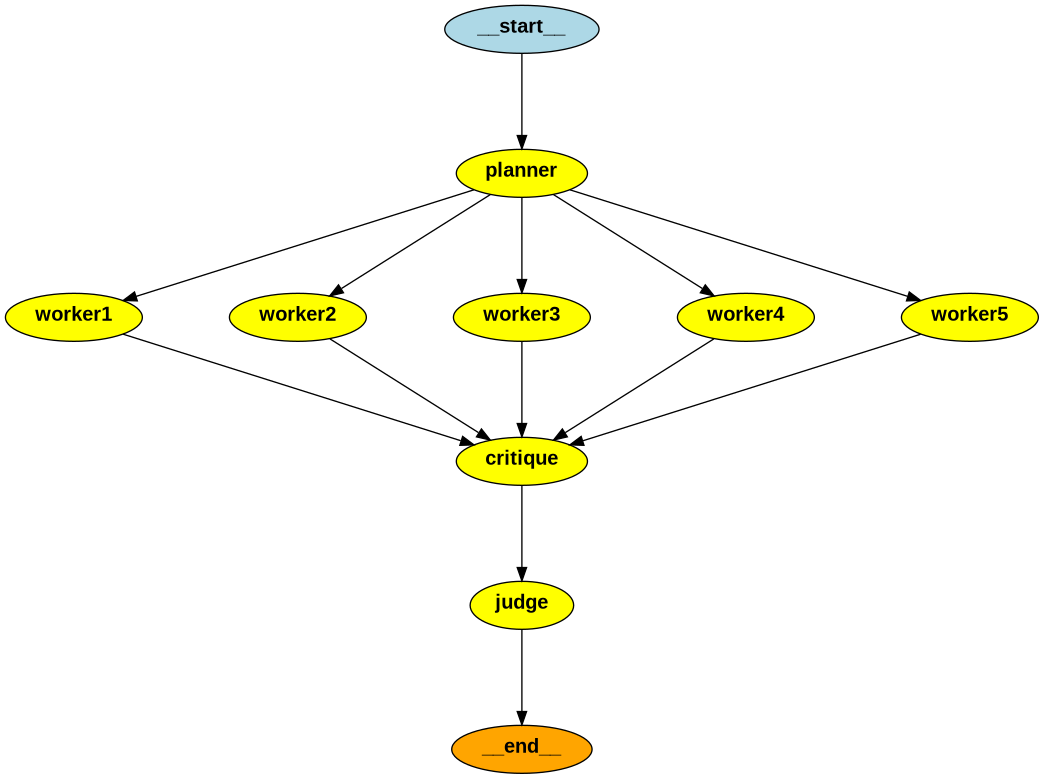


>>> PLANNER START
PLANNER: Mapped 'Initial Access Specialist' to valid role
PLANNER: Added worker with role 'Initial Access Specialist' and tasks: Access Specialist: Analyze logs for unusual login attempts and use of compromised credentials, focus...
PLANNER: Mapped 'Execution Specialist' to valid role
PLANNER: Added worker with role 'Execution Specialist' and tasks: Specialist: Investigate command line arguments and execution of suspicious processes, focusing on Pr...
PLANNER: Mapped 'Lateral Movement Specialist' to valid role
PLANNER: Added worker with role 'Lateral Movement Specialist' and tasks: Movement Specialist: Identify connections to remote systems and use of administrative shares, focusi...
PLANNER: Mapped 'Discovery Specialist' to valid role
PLANNER: Added worker with role 'Discovery Specialist' and tasks: Specialist: Examine DNS queries and network scanning activities, focusing on NetworkConnectionEvents...
PLANNER: Mapped 'Privilege Escalation Specialist' to valid role
P

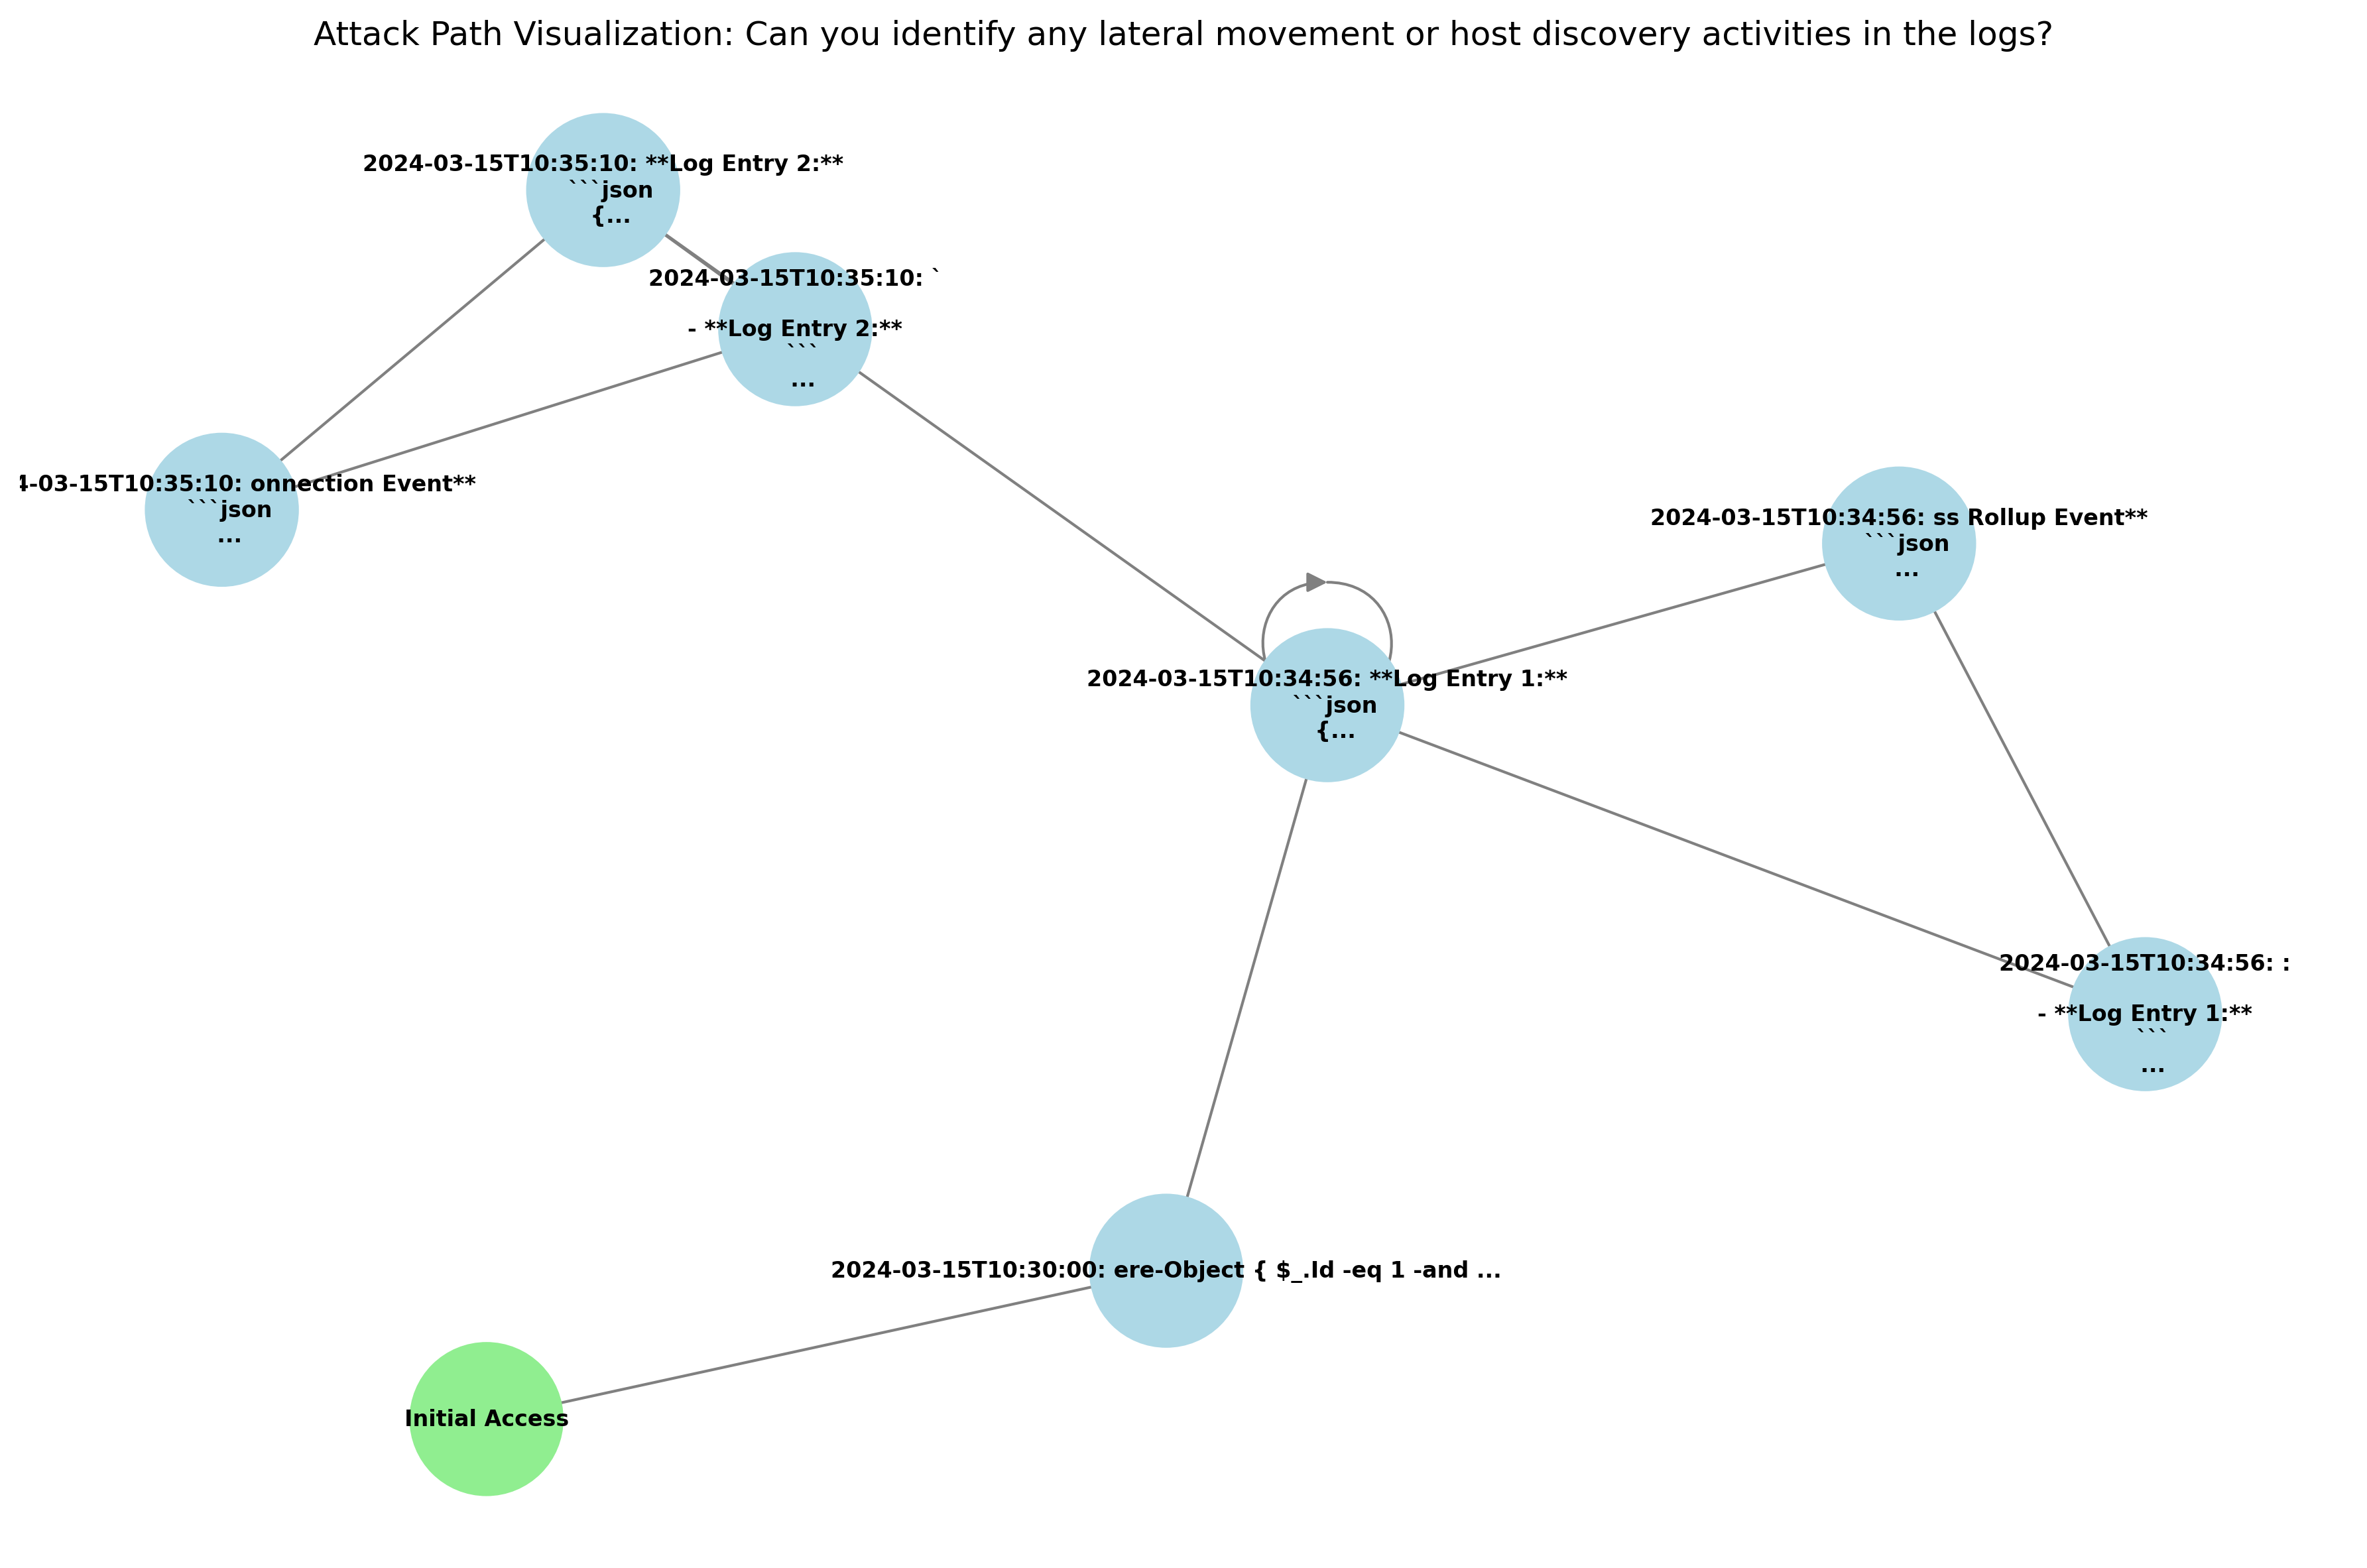

- confidence_levels: output/confidence_levels.png


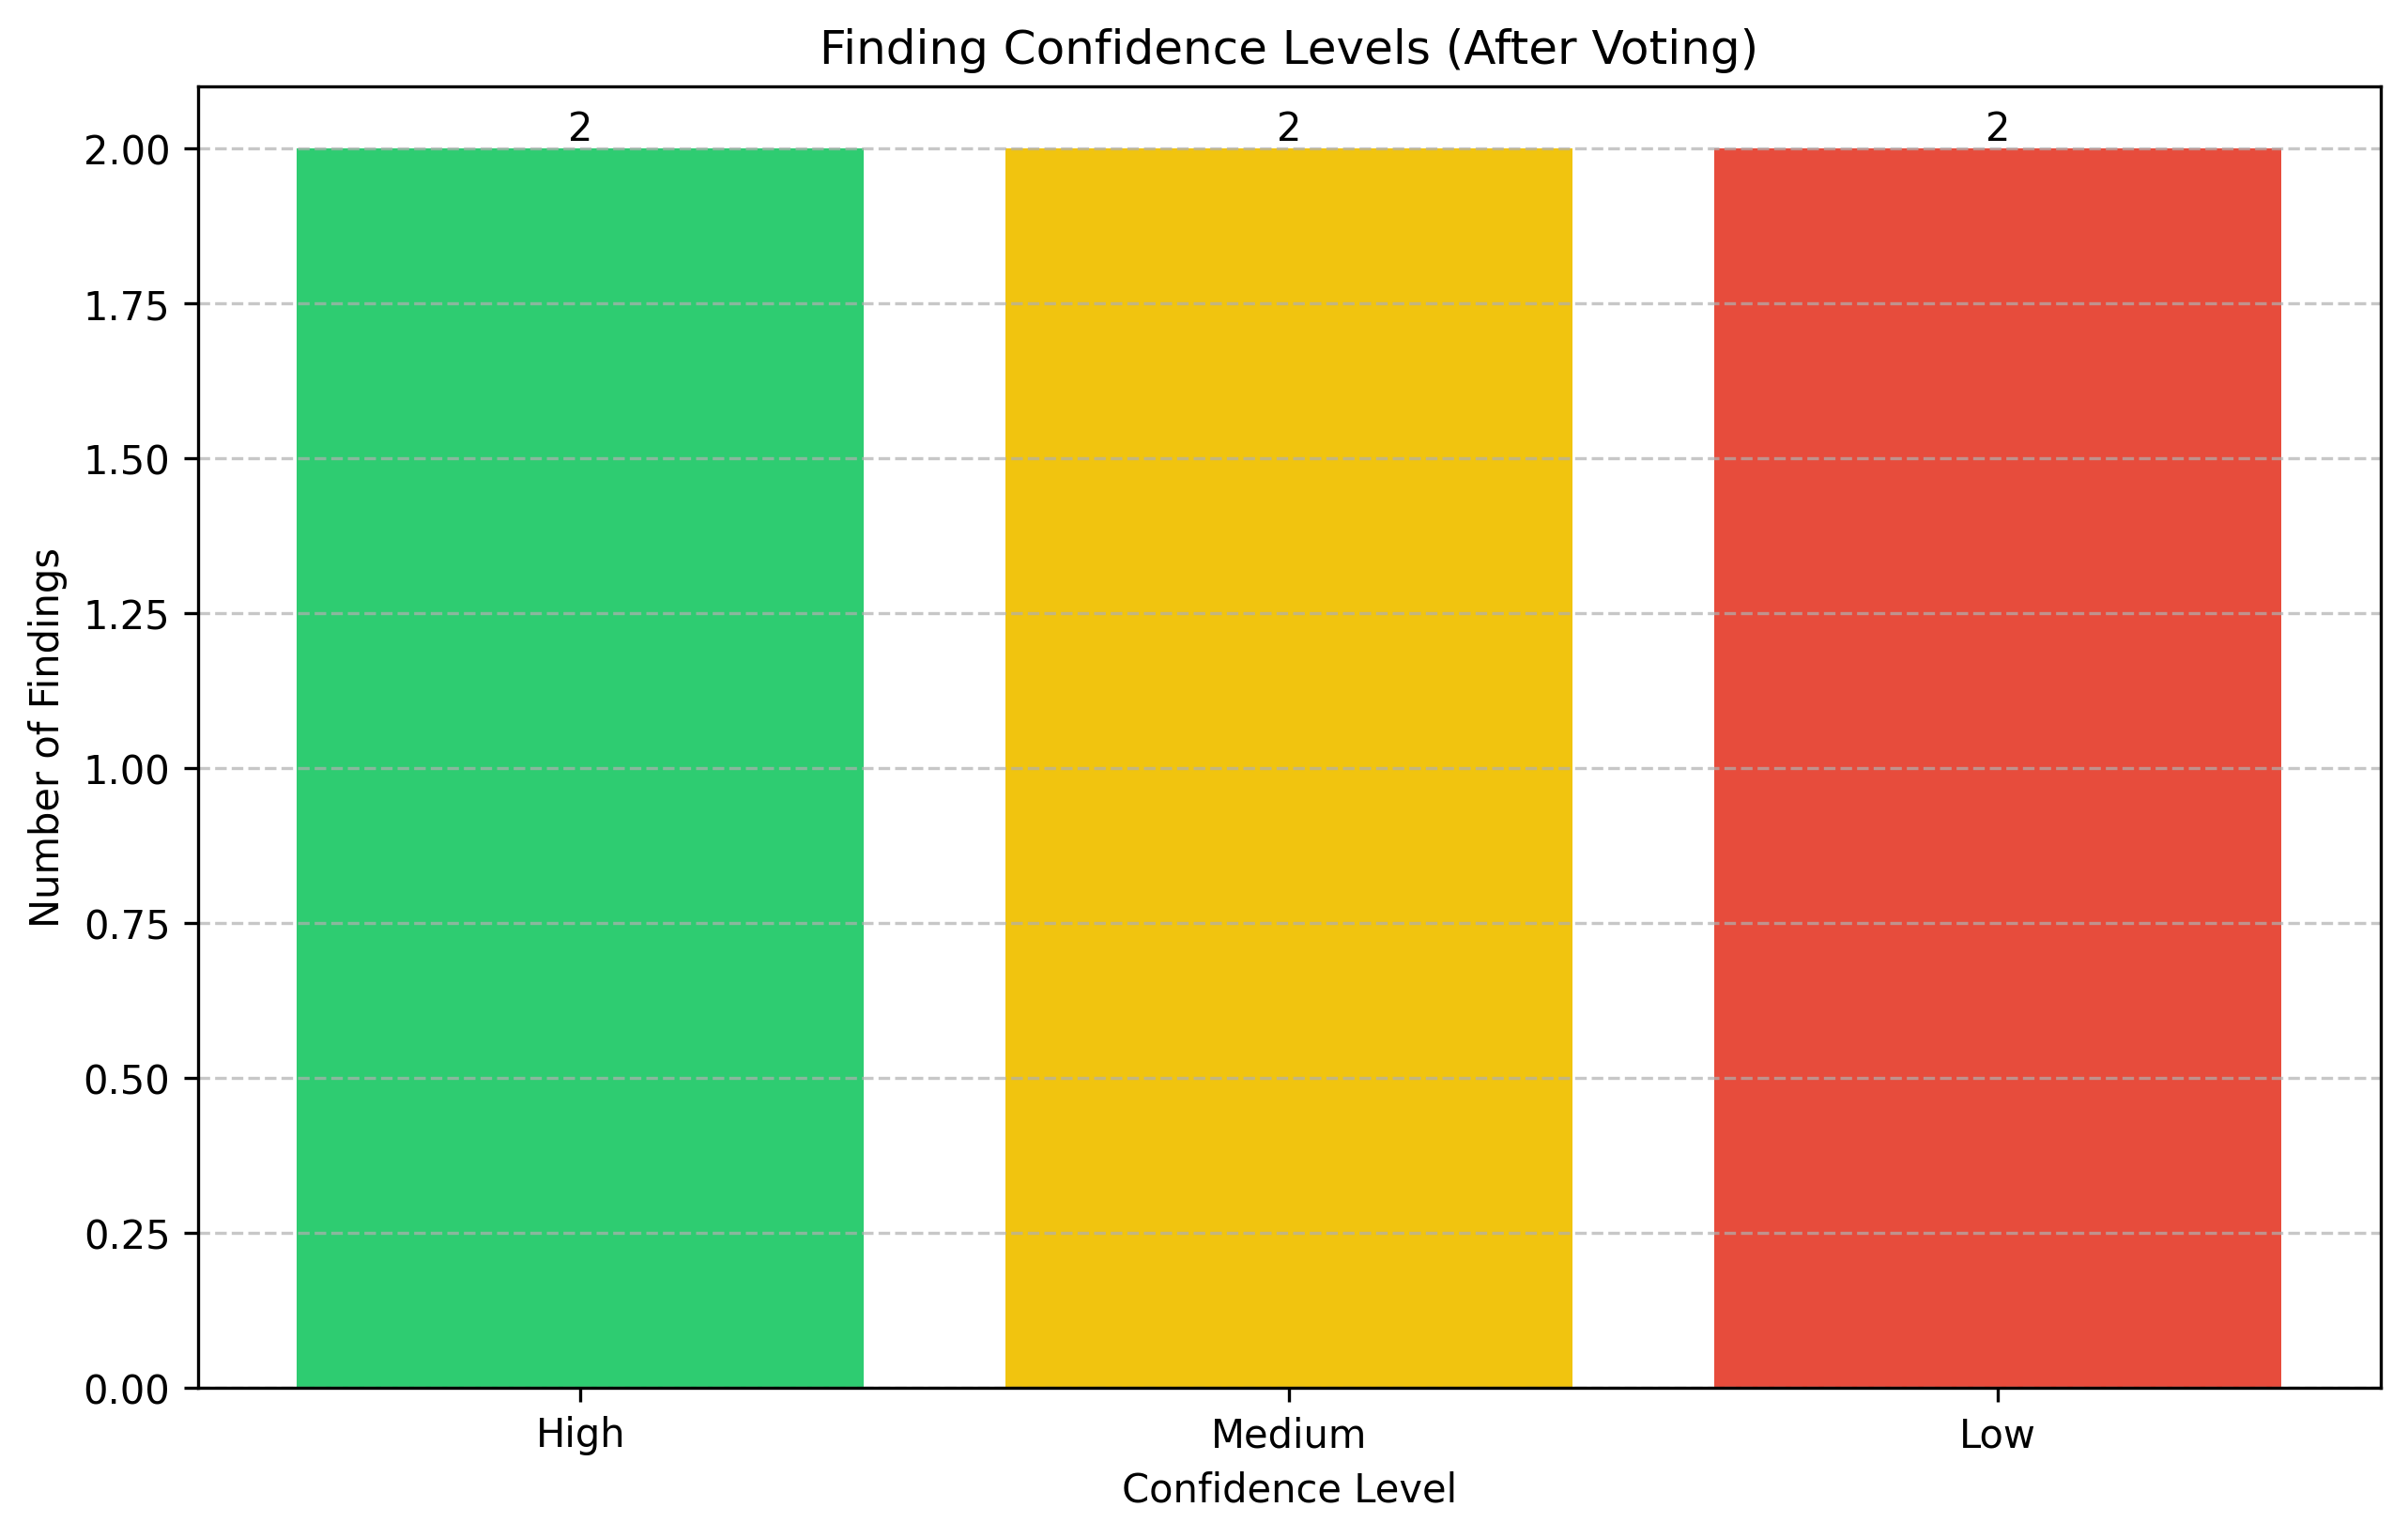

- specialist_contributions: output/specialist_contributions.png


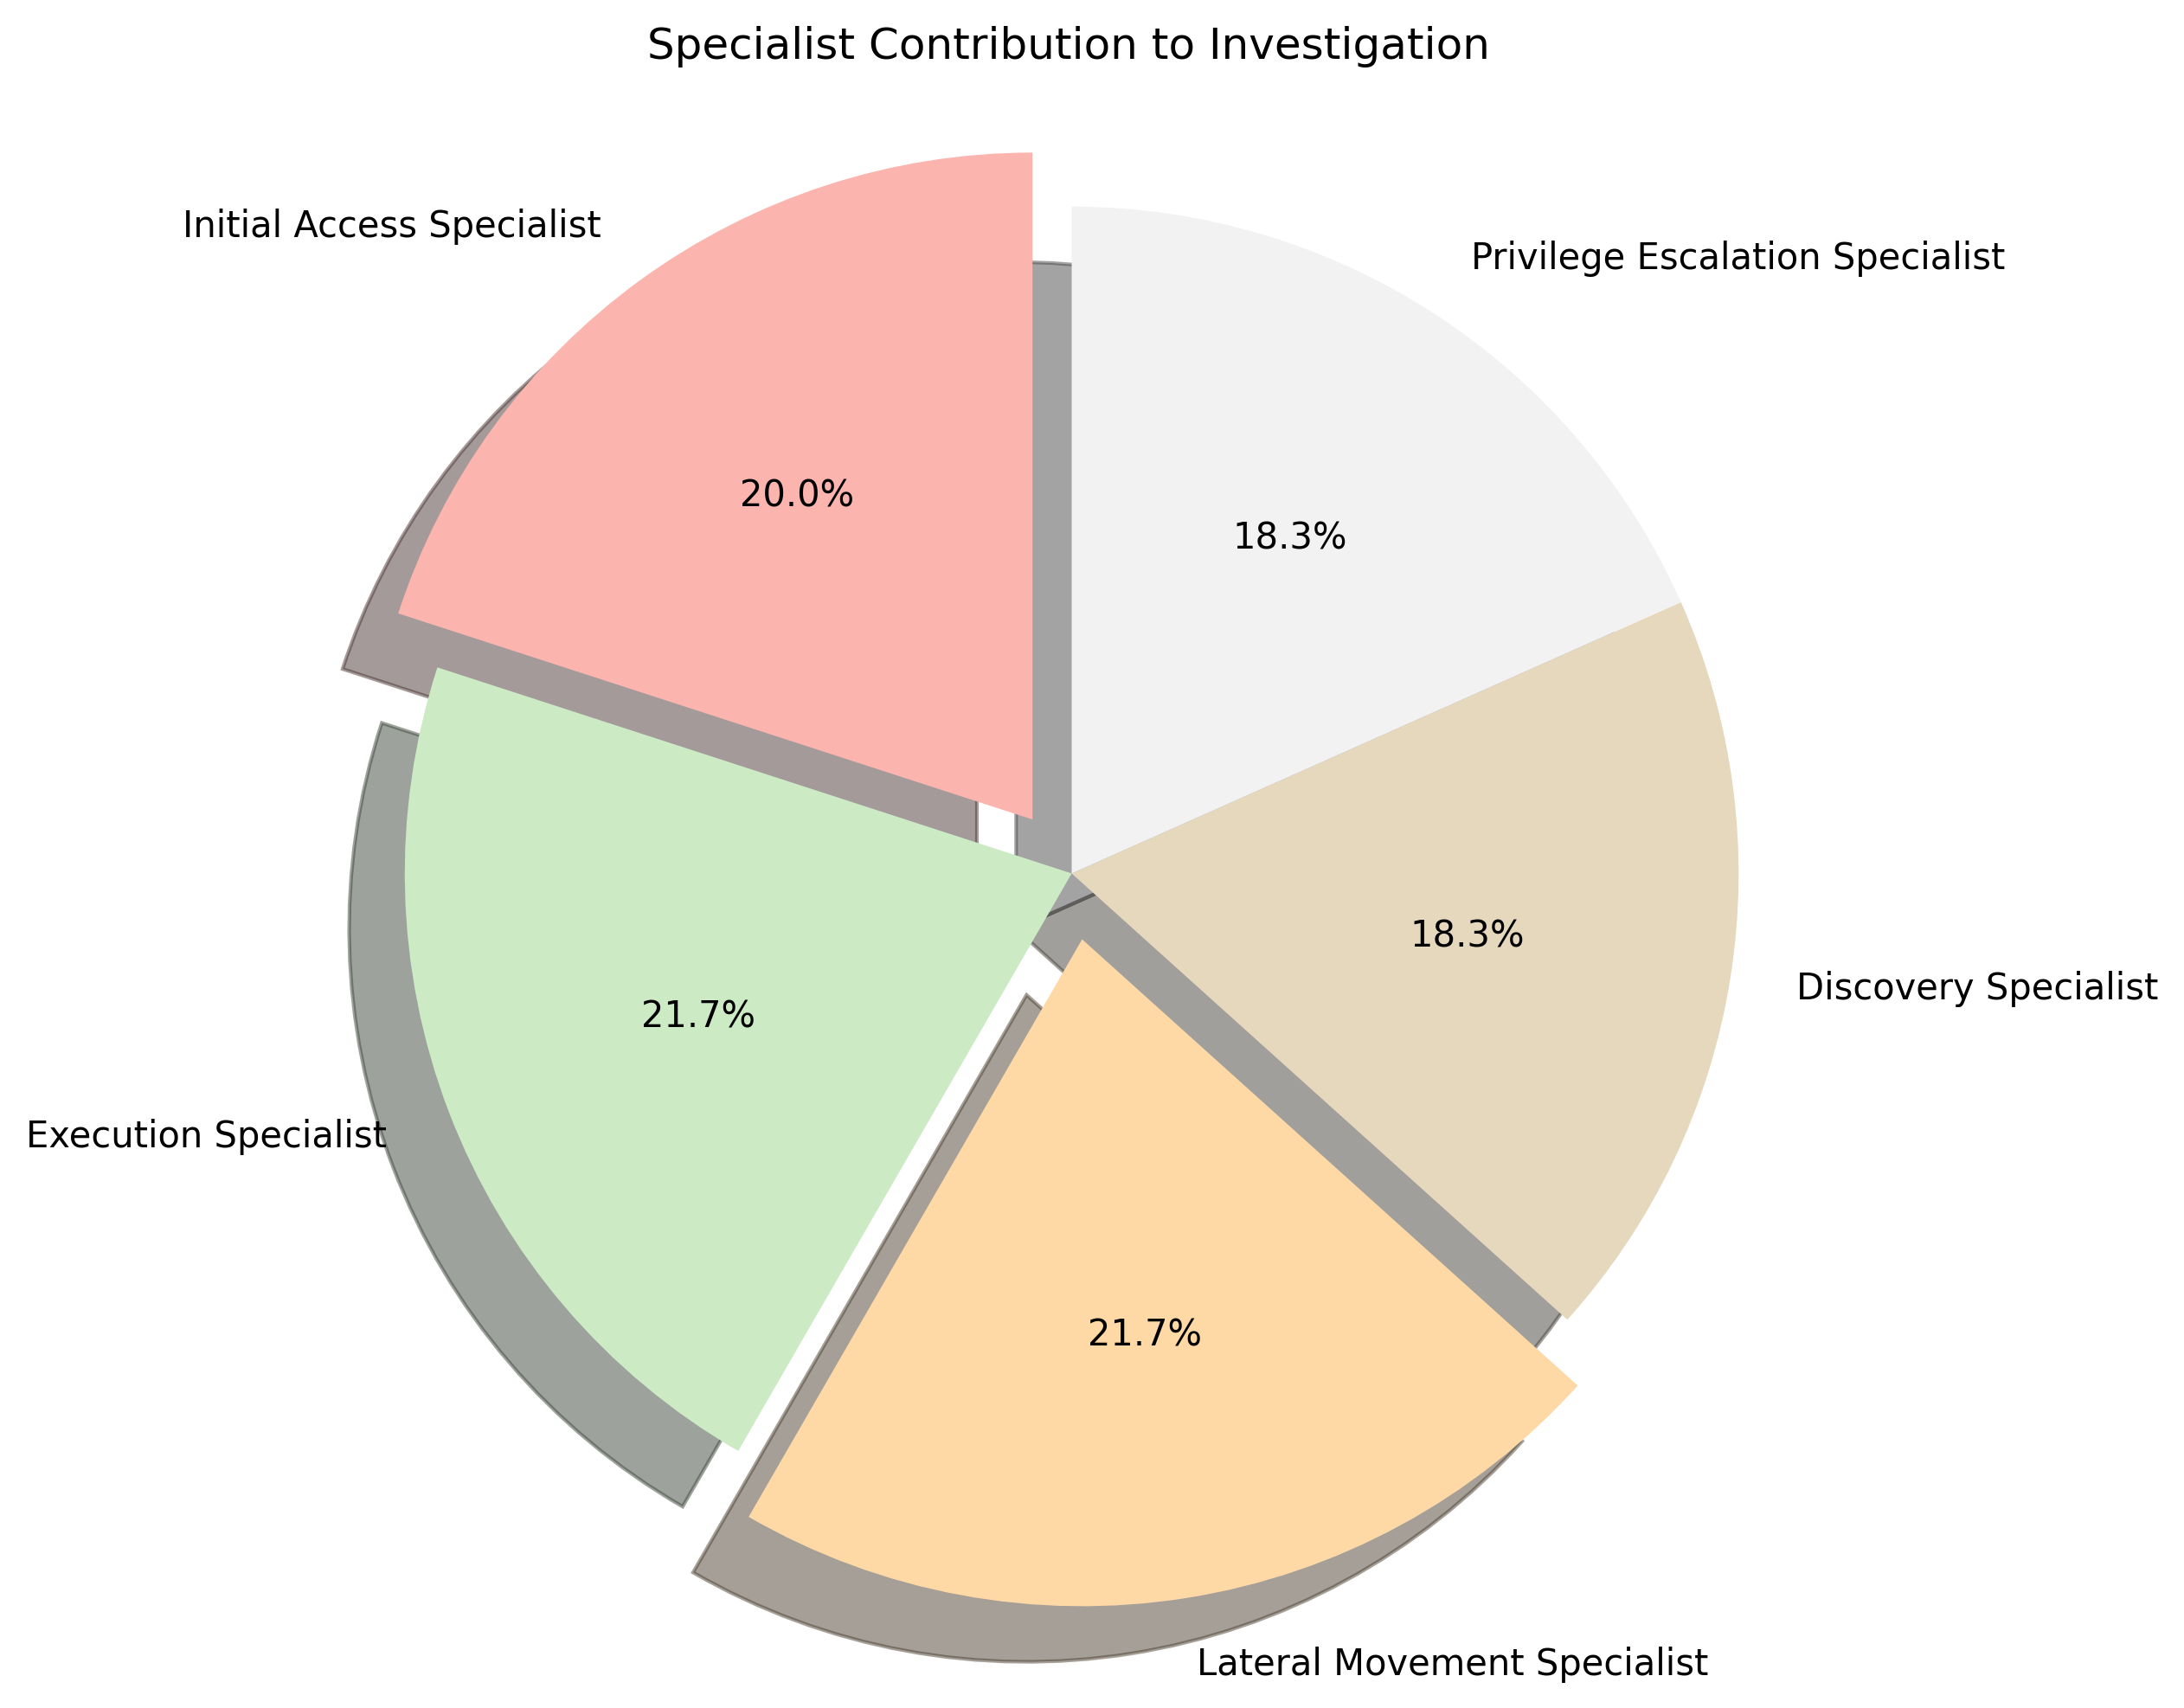

In [29]:
# Run the lateral movement scenario for demonstration
lateral_movement_result = run_demo("lateral_movement")

## Try Another Scenario

Let's try another scenario to showcase the system's versatility.

In [ ]:
# Run the credential theft scenario
credential_theft_result = run_demo("credential_theft")

## Interactive Demo

You can run the cell below to choose a scenario interactively.

In [ ]:
# Interactive demo - choose your own scenario
interactive_result = run_demo()

## System Architecture Deep Dive

Let's examine the system architecture more closely. The key components include:

1. **Parallel Execution Model**: The system runs 5 specialist workers simultaneously, each focusing on different MITRE ATT&CK tactics and techniques.

2. **Voting-Based Consensus**: The Critique agent implements a voting mechanism where:
   - High Confidence: 3+ specialists agree
   - Medium Confidence: 2 specialists agree
   - Low Confidence: Single specialist identifies

3. **Visualization Capabilities**: The system generates visualizations for:
   - Attack graph with timeline
   - Finding confidence levels
   - Specialist contribution analysis

4. **MITRE ATT&CK Alignment**: Workers are specialized in specific MITRE tactics:
   - Initial Access Specialist
   - Execution Specialist
   - Persistence Specialist
   - Privilege Escalation Specialist
   - Defense Evasion Specialist
   - Credential Access Specialist
   - Discovery Specialist
   - Lateral Movement Specialist
   - Collection Specialist
   - Exfiltration Specialist

## Summary

This notebook demonstrates a sophisticated multi-agent system for security log analysis with several key innovations:

1. **Specialized Analysis**: The system employs 5 parallel specialist workers aligned with MITRE ATT&CK tactics for comprehensive coverage of security threats.

2. **Consensus Mechanism**: The voting-based approach ensures high-confidence findings are prioritized, reducing false positives.

3. **Actionable Remediation**: The Judge agent provides specific, executable commands for addressing security issues.

4. **Visual Insights**: Visualizations enhance understanding of complex attack patterns and finding confidence.

5. **Scalable Architecture**: The system efficiently handles large log volumes through intelligent sampling.

This approach significantly enhances security log analysis by combining specialized expertise, parallel processing, and consensus-building.